In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed
import seaborn as sns
import matplotlib.patches as mpatches
from ROOT import Math
from sklearn.metrics import confusion_matrix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Instructions for updating:
non-resource variables are not supported in the long term
Welcome to JupyROOT 6.24/06


In [2]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cuda:1 device


In [3]:
batch_size=512
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

decaymodes = ['rhorho', 'a1rho', 'a1a1']
decaymode = decaymodes[0]  ###### Change this to corresponding decaymode ############

parser.add_argument("-i", "--input", dest="IN", default='HiggsCP_data/'+ decaymode)
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_'+ decaymode)

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=False)
parser.add_argument("-PtEtaPhi", dest="PTETAPHI", type=bool, default=True)
args, unknown = parser.parse_known_args()
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default= 'Ztt_dataset_Elz/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
args, unknown = parser.parse_known_args()


In [4]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']
if args.REPRO:
#     for decaymode in tqdm(decaymodes):
    args.IN = 'HiggsCP_data/'+decaymode
    args.TYPE = 'nn_'+decaymode
    data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
    event = eval(events[args.TYPE])(data, args)
    rhorho_raw_H = event.cols[:, :-1]
    df_rhorho_raw_H = pd.DataFrame(rhorho_raw_H)
    df_rhorho_raw_H.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
    particle_PtEtaPhi={}
    for particle in particle_name:
        total_res={}
        for index, row in tqdm(df_rhorho_raw_H[particle].iloc[:, :4].iterrows(),total=df_rhorho_raw_H[particle].iloc[:, :4].shape[0]):
            res=Math.PxPyPzEVector(*row.values.tolist())
            total_res[index]=(res.pt(), res.eta(), res.phi(), row.E)
        particle_PtEtaPhi[particle]=total_res
    PtEtaPhi = [pd.DataFrame(particle_PtEtaPhi[particle].values(),columns=[particle+x for x in ['_pt','_eta','_phi','_E']]) for particle in particle_name]
    PtEtaPhi=pd.concat(PtEtaPhi,axis=1)

In [16]:
# PtEtaPhi.to_csv('PtEtaPhi_data/PtEtaPhi_after_preprocessing.csv',index=False)

In [17]:
PtEtaPhi = pd.read_csv('PtEtaPhi_data/PtEtaPhi_after_preprocessing.csv')

In [40]:
PtEtaPhi

,n_pt,n_eta,n_phi,n_E,pi-_pt,pi-_eta,pi-_phi,pi-_E,pi0_1_pt,pi0_1_eta,...,an_phi,an_E,pi+_pt,pi+_eta,pi+_phi,pi+_E,pi0_2_pt,pi0_2_eta,pi0_2_phi,pi0_2_E
0,0.839444,-3.542624,-2.623961,14.516693,0.277982,-5.642304,-2.985253,39.211730,0.277982,-4.319244,...,2.007669,11.210881,0.380973,5.421233,0.018635,43.081105,0.380973,3.541844,-3.122957,6.584508
1,0.974434,-3.662469,-1.196898,18.993222,0.223126,-4.512335,-0.729067,10.169405,0.223126,-5.908249,...,2.242125,4.371543,0.373978,5.068659,-0.251537,29.725449,0.373978,4.745063,2.890056,21.508598
2,2.606788,-4.446975,-0.056839,111.283789,0.099935,-6.001500,-1.541254,20.189233,0.099935,-3.864057,...,-1.268165,6.540253,0.305417,2.775145,2.115472,2.463068,0.305417,4.881430,-1.026121,20.131532
3,0.634588,-2.617316,1.833557,4.369753,0.050972,-6.946901,0.913955,26.503905,0.050972,-3.830686,...,-0.183923,94.259541,0.392637,4.121320,-2.508910,12.105164,0.392637,4.374145,0.632683,15.585233
4,1.795684,-4.087925,-0.313429,53.540873,0.280995,-4.269824,2.912927,10.049761,0.280995,-5.061986,...,3.048777,12.623745,0.193658,3.625655,-1.077252,3.641113,0.193658,5.688080,2.064341,28.596732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.091544,-4.815763,0.148092,67.375031,0.264541,-3.297293,1.394512,3.584123,0.264541,-5.126799,...,0.034600,16.049533,0.356005,3.808690,-0.247922,8.031542,0.356005,4.607104,2.893670,17.837009
999996,1.366647,-4.360027,-1.318174,53.485125,0.365530,-3.812094,-2.964703,8.274436,0.365530,-4.751756,...,1.540750,17.547289,0.283424,3.750016,1.099534,6.030804,0.283424,5.106856,-2.042059,23.405066
999997,0.266724,-1.984793,0.554599,0.988923,0.239089,-4.639642,3.105810,12.375678,0.239089,-5.373808,...,0.069924,61.672772,0.273181,4.277704,0.217220,9.847626,0.273181,5.334107,-2.924373,28.314525
999998,0.378486,-2.577450,-1.505948,2.505503,0.311091,-5.365446,1.928116,33.270136,0.311091,-4.014425,...,-0.527062,46.143536,0.111951,4.457835,0.480160,4.833381,0.111951,6.495148,-2.661432,37.051820


In [18]:
PtEtaDphi = PtEtaPhi.copy(deep=True)

In [20]:
PtEtaDphi.insert(PtEtaDphi.shape[1], 'n_dphi', PtEtaPhi['n_phi']-PtEtaPhi['an_phi'])
PtEtaDphi.insert(PtEtaDphi.shape[1], 'pi-_dphi', PtEtaPhi['pi-_phi']-PtEtaPhi['pi+_phi'])
PtEtaDphi.insert(PtEtaDphi.shape[1], 'pi0_dphi', PtEtaPhi['pi0_1_phi']-PtEtaPhi['pi0_2_phi'])

In [21]:
PtEtaDphi['n_dphi'] = [dphi + 2* math.pi if dphi < 0 else dphi for dphi in PtEtaDphi['n_dphi']]
PtEtaDphi['pi-_dphi'] = [dphi + 2* math.pi if dphi < 0 else dphi for dphi in PtEtaDphi['pi-_dphi']]
PtEtaDphi['pi0_dphi'] = [dphi + 2* math.pi if dphi < 0 else dphi for dphi in PtEtaDphi['pi0_dphi']]

In [22]:
PtEtaDphi.insert(PtEtaDphi.shape[1], 'filter', event.cols[:,-1])

In [32]:
PtEtaDphi

,n_pt,n_eta,n_phi,n_E,pi-_pt,pi-_eta,pi-_phi,pi-_E,pi0_1_pt,pi0_1_eta,...,pi+_phi,pi+_E,pi0_2_pt,pi0_2_eta,pi0_2_phi,pi0_2_E,n_dphi,pi-_dphi,pi0_dphi,filter
0,0.839444,-3.542624,-2.623961,14.516693,0.277982,-5.642304,-2.985253,39.211730,0.277982,-4.319244,...,0.018635,43.081105,0.380973,3.541844,-3.122957,6.584508,1.651556,3.279297,3.279297,0.0
1,0.974434,-3.662469,-1.196898,18.993222,0.223126,-4.512335,-0.729067,10.169405,0.223126,-5.908249,...,-0.251537,29.725449,0.373978,4.745063,2.890056,21.508598,2.844162,5.805655,5.805655,1.0
2,2.606788,-4.446975,-0.056839,111.283789,0.099935,-6.001500,-1.541254,20.189233,0.099935,-3.864057,...,2.115472,2.463068,0.305417,4.881430,-1.026121,20.131532,1.211326,2.626459,2.626459,0.0
3,0.634588,-2.617316,1.833557,4.369753,0.050972,-6.946901,0.913955,26.503905,0.050972,-3.830686,...,-2.508910,12.105164,0.392637,4.374145,0.632683,15.585233,2.017481,3.422865,3.422865,0.0
4,1.795684,-4.087925,-0.313429,53.540873,0.280995,-4.269824,2.912927,10.049761,0.280995,-5.061986,...,-1.077252,3.641113,0.193658,5.688080,2.064341,28.596732,2.920979,3.990178,3.990178,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.091544,-4.815763,0.148092,67.375031,0.264541,-3.297293,1.394512,3.584123,0.264541,-5.126799,...,-0.247922,8.031542,0.356005,4.607104,2.893670,17.837009,0.113491,1.642435,1.642435,0.0
999996,1.366647,-4.360027,-1.318174,53.485125,0.365530,-3.812094,-2.964703,8.274436,0.365530,-4.751756,...,1.099534,6.030804,0.283424,5.106856,-2.042059,23.405066,3.424262,2.218948,2.218948,0.0
999997,0.266724,-1.984793,0.554599,0.988923,0.239089,-4.639642,3.105810,12.375678,0.239089,-5.373808,...,0.217220,9.847626,0.273181,5.334107,-2.924373,28.314525,0.484675,2.888590,2.888590,1.0
999998,0.378486,-2.577450,-1.505948,2.505503,0.311091,-5.365446,1.928116,33.270136,0.311091,-4.014425,...,0.480160,4.833381,0.111951,6.495148,-2.661432,37.051820,5.304299,1.447956,1.447956,1.0


In [24]:
event.cols=PtEtaDphi.values
points = EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs,  hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED, raw=False)
#         By setting raw=True, the scaling of the features will be skipped        
pickle.dump(points,open(args.IN+'/events_wo_background_PtEtaDphi_'+str(args.NUM_CLASSES)+'.pk','wb'))

SCALE!!


In [5]:
points=pickle.load(open(args.IN+'/events_wo_background_PtEtaDphi_'+str(args.NUM_CLASSES)+'.pk','rb'))

In [6]:
class MyDataset(Dataset):
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        
        self.rhorho_labels_mc =torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true =torch.from_numpy(rhorho_labels_true).float().to(device)
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [8]:
mc_train_idx=np.random.choice(np.arange(points.train.x.shape[0]),int(points.train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points.train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points.valid.x.shape[0]),int(points.valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points.valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points.test.x.shape[0]),int(points.test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points.test.x.shape[0]))-set(mc_train_idx))

In [9]:
uncertainty=0.0

train_datasets_truth = MyDataset(points.train.x[mc_train_idx], points.train.x[true_train_idx]+uncertainty*np.random.normal(0,1,size=points.train.x[true_train_idx].shape),
                          points.train.weights[mc_train_idx],points.train.weights[true_train_idx])
train_loader_truth = DataLoader(dataset = train_datasets_truth,batch_size = batch_size,shuffle = True)


valid_datasets_truth = MyDataset(points.valid.x[mc_valid_idx], points.valid.x[true_valid_idx]+uncertainty*np.random.normal(0,1,size=points.valid.x[true_valid_idx].shape),
                          points.valid.weights[mc_valid_idx],points.valid.weights[true_valid_idx])
valid_loader_truth = DataLoader(dataset = valid_datasets_truth,batch_size = batch_size,shuffle = True)


test_datasets_truth = MyDataset(points.test.x[mc_test_idx], points.test.x[true_test_idx]+uncertainty*np.random.normal(0,1,size=points.test.x[true_test_idx].shape),
                          points.test.weights[mc_test_idx],points.test.weights[true_test_idx])
test_loader_truth = DataLoader(dataset = test_datasets_truth,batch_size = batch_size,shuffle = True)

In [10]:
model_path = os.path.join(os.getcwd() + '/model')
if not os.path.exists(model_path): 
    os.mkdir(os.path.join(model_path))
model = NeuralNetwork(num_features=points.train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
# model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.CrossEntropyLoss()
if not args.PTETAPHI: 
    early_stopping = EarlyStopping(patience=50, verbose=True,path=model_path+'/'+decaymode+'_best_model_'+str(args.NUM_CLASSES)+'.pt')
else:
    early_stopping = EarlyStopping(patience=50, verbose=True,path=model_path+'/'+decaymode+'_best_model_PtEtaDphi_'+str(args.NUM_CLASSES)+'.pt')

In [11]:
epoch=400
labels = {'train':[], 'valid': [], 'test': []}
predict = {'train':[], 'valid': [], 'test': []}
losses = {'train':[], 'valid': [], 'test': []}
if not args.PTETAPHI: 
    Training_output_path='Results/TrainingOutputs/'+decaymode+'_TrainingOutputs_'+str(args.NUM_CLASSES)+'.txt'
else:
    Training_output_path='Results/TrainingOutputs/'+decaymode+'_TrainingOutputs_PtEtaDphi_'+str(args.NUM_CLASSES)+'.txt'
with open(Training_output_path,'wb') as f:
    for i in range(epoch):
        model.train()
        train_loss,sample_numbers,acc,total_samples,bg_acc=0,0,0,0,0
        for batch_idx, (rhorho_s,rhorho_t,label_s,_) in enumerate(train_loader_truth):
            opt_g.zero_grad()
            rhorho_s=rhorho_s[label_s.sum(axis=1)!=0]
            label_s=label_s[label_s.sum(axis=1)!=0]
            labels['train'].append(label_s.cpu().detach())
            outputs=model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_s,axis=1))
                _, predictions = torch.max(outputs, 1)
                predict['train'].append(predictions.cpu().detach())
                acc+=(predictions==torch.argmax(label_s,axis=1)).sum().item()
            else:
                loss=criterion(outputs,label_s)
            loss.backward()
            train_loss+=loss.item()*len(rhorho_s)
            sample_numbers+=len(rhorho_s)
            opt_g.step()
            print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/sample_numbers,acc/sample_numbers),end='')
        f.write(('\r training loss: %.3f \t acc: %.3f \t ' %(train_loss/sample_numbers,acc/sample_numbers)).encode())
        print()
        losses['train'].append(train_loss/sample_numbers)
        
        valid_loss,valid_acc,valid_numbers,total_samples,bg_acc=0,0,0,0,0
        model.eval()
        with torch.no_grad():
            for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader_truth):
                total_samples+=len(rhorho_t)
                rhorho_t= rhorho_t[label_t.sum(axis=1)!=0]
                label_t = label_t[label_t.sum(axis=1)!=0]
                labels['valid'].append(label_t.cpu().detach())
                outputs=model(rhorho_t)
                _, predictions = torch.max(outputs, 1)
                predict['valid'].append(predictions.cpu().detach())
                valid_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
                valid_numbers+=len(rhorho_t)
                if isinstance(criterion,nn.CrossEntropyLoss):
                    loss=criterion(outputs,torch.argmax(label_t,axis=1))
                else:
                    loss=criterion(outputs,label_t)
                valid_loss+=loss.item()*len(rhorho_t) 
                
        print()
        print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
        f.write(('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers)).encode())
        print()
        losses['valid'].append(valid_loss/valid_numbers)
        early_stopping(-valid_acc/valid_numbers,model)
        if early_stopping.early_stop:
            print("Early stopping")
            f.write(("Early stopping").encode())
            break;
            
    test_loss,test_acc,test_numbers,total_samples,bg_acc=0,0,0,0,0
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(test_loader_truth):
            total_samples+=len(rhorho_t)
            rhorho_t= rhorho_t[label_t.sum(axis=1)!=0]
            label_t = label_t[label_t.sum(axis=1)!=0]
            labels['test'].append(label_t.cpu().detach())
            outputs=model(rhorho_t)
            _, predictions = torch.max(outputs, 1)
            predict['test'].append(predictions.cpu().detach())
            test_acc+=(predictions==torch.argmax(label_t,axis=1)).sum().item()
            test_numbers+=len(rhorho_t)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_t,axis=1))
            else:
                loss=criterion(outputs,label_t)
            test_loss+=loss.item()*len(rhorho_t) 
            
    print()
    print('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers,test_acc/test_numbers),end='')
    f.write(('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers,test_acc/test_numbers)).encode())
    print()
    losses['test'].append(test_loss/test_numbers)

 training loss: 1.810 	 acc: 0.321 	

 validation loss: 1.460 	 acc: 0.425 	
Validation loss decreased (inf --> -0.424624).  Saving model ...
 training loss: 1.314 	 acc: 0.476 	

 validation loss: 1.126 	 acc: 0.546 	
Validation loss decreased (-0.424624 --> -0.545976).  Saving model ...
 training loss: 1.122 	 acc: 0.541 	

 validation loss: 1.029 	 acc: 0.576 	
Validation loss decreased (-0.545976 --> -0.576340).  Saving model ...
 training loss: 1.026 	 acc: 0.576 	

 validation loss: 0.902 	 acc: 0.632 	
Validation loss decreased (-0.576340 --> -0.632189).  Saving model ...
 training loss: 0.973 	 acc: 0.596 	

 validation loss: 0.856 	 acc: 0.649 	
Validation loss decreased (-0.632189 --> -0.649328).  Saving model ...
 training loss: 0.927 	 acc: 0.614 	

 validation loss: 0.829 	 acc: 0.658 	
Validation loss decreased (-0.649328 --> -0.658378).  Saving model ...
 training loss: 0.892 	 acc: 0.628 	

 validation loss: 0.765 	 acc: 0.689 	
Validation loss decreased (-0.658378 --> 

 training loss: 0.575 	 acc: 0.758 	

 validation loss: 0.474 	 acc: 0.805 	
EarlyStopping counter: 3 out of 50
 training loss: 0.572 	 acc: 0.759 	

 validation loss: 0.485 	 acc: 0.799 	
EarlyStopping counter: 4 out of 50
 training loss: 0.575 	 acc: 0.758 	

 validation loss: 0.467 	 acc: 0.812 	
Validation loss decreased (-0.809613 --> -0.812322).  Saving model ...
 training loss: 0.568 	 acc: 0.760 	

 validation loss: 0.465 	 acc: 0.811 	
EarlyStopping counter: 1 out of 50
 training loss: 0.564 	 acc: 0.762 	

 validation loss: 0.471 	 acc: 0.807 	
EarlyStopping counter: 2 out of 50
 training loss: 0.566 	 acc: 0.761 	

 validation loss: 0.470 	 acc: 0.810 	
EarlyStopping counter: 3 out of 50
 training loss: 0.563 	 acc: 0.763 	

 validation loss: 0.461 	 acc: 0.812 	
Validation loss decreased (-0.812322 --> -0.812382).  Saving model ...
 training loss: 0.559 	 acc: 0.764 	

 validation loss: 0.465 	 acc: 0.812 	
EarlyStopping counter: 1 out of 50
 training loss: 0.561 	 acc: 0.7

 training loss: 0.504 	 acc: 0.789 	

 validation loss: 0.428 	 acc: 0.824 	
EarlyStopping counter: 5 out of 50
 training loss: 0.501 	 acc: 0.790 	

 validation loss: 0.422 	 acc: 0.827 	
EarlyStopping counter: 6 out of 50
 training loss: 0.502 	 acc: 0.788 	

 validation loss: 0.421 	 acc: 0.829 	
EarlyStopping counter: 7 out of 50
 training loss: 0.502 	 acc: 0.788 	

 validation loss: 0.419 	 acc: 0.830 	
EarlyStopping counter: 8 out of 50
 training loss: 0.502 	 acc: 0.789 	

 validation loss: 0.420 	 acc: 0.828 	
EarlyStopping counter: 9 out of 50
 training loss: 0.505 	 acc: 0.788 	

 validation loss: 0.422 	 acc: 0.826 	
EarlyStopping counter: 10 out of 50
 training loss: 0.505 	 acc: 0.788 	

 validation loss: 0.416 	 acc: 0.832 	
EarlyStopping counter: 11 out of 50
 training loss: 0.499 	 acc: 0.791 	

 validation loss: 0.415 	 acc: 0.832 	
EarlyStopping counter: 12 out of 50
 training loss: 0.499 	 acc: 0.790 	

 validation loss: 0.424 	 acc: 0.825 	
EarlyStopping counter: 1

 training loss: 0.474 	 acc: 0.801 	

 validation loss: 0.400 	 acc: 0.839 	
Validation loss decreased (-0.838330 --> -0.838511).  Saving model ...
 training loss: 0.476 	 acc: 0.800 	

 validation loss: 0.398 	 acc: 0.837 	
EarlyStopping counter: 1 out of 50
 training loss: 0.469 	 acc: 0.803 	

 validation loss: 0.401 	 acc: 0.836 	
EarlyStopping counter: 2 out of 50
 training loss: 0.470 	 acc: 0.803 	

 validation loss: 0.397 	 acc: 0.836 	
EarlyStopping counter: 3 out of 50
 training loss: 0.471 	 acc: 0.803 	

 validation loss: 0.405 	 acc: 0.833 	
EarlyStopping counter: 4 out of 50
 training loss: 0.464 	 acc: 0.806 	

 validation loss: 0.403 	 acc: 0.832 	
EarlyStopping counter: 5 out of 50
 training loss: 0.469 	 acc: 0.804 	

 validation loss: 0.400 	 acc: 0.834 	
EarlyStopping counter: 6 out of 50
 training loss: 0.468 	 acc: 0.803 	

 validation loss: 0.400 	 acc: 0.836 	
EarlyStopping counter: 7 out of 50
 training loss: 0.469 	 acc: 0.803 	

 validation loss: 0.411 	 acc:

 training loss: 0.453 	 acc: 0.810 	

 validation loss: 0.388 	 acc: 0.841 	
EarlyStopping counter: 8 out of 50
 training loss: 0.448 	 acc: 0.812 	

 validation loss: 0.388 	 acc: 0.841 	
EarlyStopping counter: 9 out of 50
 training loss: 0.454 	 acc: 0.810 	

 validation loss: 0.396 	 acc: 0.838 	
EarlyStopping counter: 10 out of 50
 training loss: 0.456 	 acc: 0.809 	

 validation loss: 0.393 	 acc: 0.840 	
EarlyStopping counter: 11 out of 50
 training loss: 0.451 	 acc: 0.811 	

 validation loss: 0.389 	 acc: 0.840 	
EarlyStopping counter: 12 out of 50
 training loss: 0.453 	 acc: 0.811 	

 validation loss: 0.388 	 acc: 0.843 	
Validation loss decreased (-0.843026 --> -0.843488).  Saving model ...
 training loss: 0.457 	 acc: 0.808 	

 validation loss: 0.398 	 acc: 0.837 	
EarlyStopping counter: 1 out of 50
 training loss: 0.448 	 acc: 0.813 	

 validation loss: 0.389 	 acc: 0.839 	
EarlyStopping counter: 2 out of 50
 training loss: 0.447 	 acc: 0.813 	

 validation loss: 0.388 	 a

 training loss: 0.437 	 acc: 0.817 	

 validation loss: 0.384 	 acc: 0.842 	
EarlyStopping counter: 10 out of 50
 training loss: 0.437 	 acc: 0.818 	

 validation loss: 0.388 	 acc: 0.839 	
EarlyStopping counter: 11 out of 50
 training loss: 0.438 	 acc: 0.817 	

 validation loss: 0.385 	 acc: 0.843 	
EarlyStopping counter: 12 out of 50
 training loss: 0.440 	 acc: 0.817 	

 validation loss: 0.385 	 acc: 0.842 	
EarlyStopping counter: 13 out of 50
 training loss: 0.436 	 acc: 0.817 	

 validation loss: 0.391 	 acc: 0.838 	
EarlyStopping counter: 14 out of 50
 training loss: 0.438 	 acc: 0.817 	

 validation loss: 0.380 	 acc: 0.844 	
EarlyStopping counter: 15 out of 50
 training loss: 0.436 	 acc: 0.817 	

 validation loss: 0.385 	 acc: 0.842 	
EarlyStopping counter: 16 out of 50
 training loss: 0.439 	 acc: 0.817 	

 validation loss: 0.388 	 acc: 0.841 	
EarlyStopping counter: 17 out of 50
 training loss: 0.440 	 acc: 0.816 	

 validation loss: 0.403 	 acc: 0.831 	
EarlyStopping count

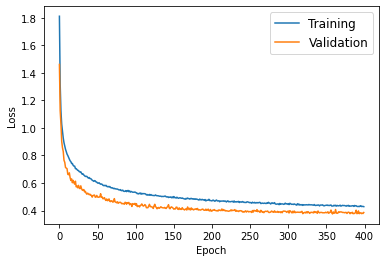

In [12]:
plt.figure()
l_train = plt.plot(np.arange(len(losses['train'])),losses['train'])
l_valid = plt.plot(np.arange(len(losses['valid'])),losses['valid'])

plt.legend(labels=['Training','Validation'],loc="best",fontsize=12)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [13]:
Predicts_train=torch.cat(predict['train']).numpy()
Labels_train=np.argmax(torch.cat(labels['train']).numpy(), axis=1)

Predicts_valid=torch.cat(predict['valid']).numpy()
Labels_valid=np.argmax(torch.cat(labels['valid']).numpy(), axis=1)

Predicts_test=torch.cat(predict['test']).numpy()
Labels_test=np.argmax(torch.cat(labels['test']).numpy(), axis=1)

In [14]:
def plot_confusion_matrix(normalize=False,
                          title=None): 
    pred = {"Training": Predicts_train, "Validation": Predicts_valid, "Test": Predicts_test}
    true = {"Training": Labels_train, "Validation": Labels_valid, "Test": Labels_test}
    fig,ax=plt.subplots(1,3,figsize=(22,5))
    for idx, key in enumerate(pred.keys()):
        y_pred=pred[key]
        y_true=true[key]
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
#         print(cm)
#     Plotting
        sns.heatmap(cm,ax=ax[idx], annot=True, annot_kws={'size':8})
        ax[idx].set_title(key,fontsize=16)
        ax[idx].set_xlabel(xlabel='Predicted label',fontsize=13)
        ax[idx].set_ylabel(ylabel='True label',fontsize=13)
    plt.suptitle(title, fontsize=20)

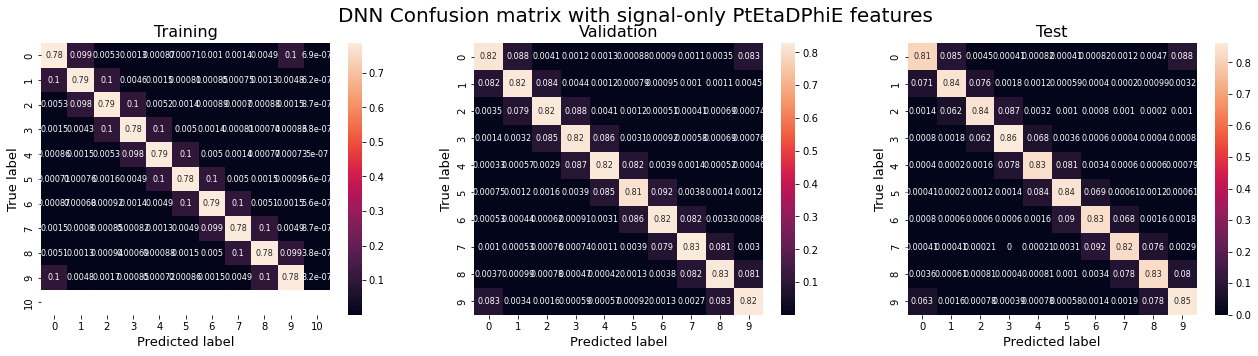

In [15]:
plot_confusion_matrix(normalize=True,
                              title='DNN Confusion matrix with signal-only PtEtaDPhiE features')